In [21]:
%%time
%matplotlib inline

import importlib
import new_import  

importlib.reload(new_import)


from new_import import *

CPU times: user 77.8 ms, sys: 240 µs, total: 78 ms
Wall time: 83.8 ms


In [22]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

client

Starting new cluster.
CPU times: user 71.6 ms, sys: 18.3 ms, total: 89.9 ms
Wall time: 3min 33s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.9b7ec414bbde4f81b8abf2babcb050b9/status,


In [39]:
# cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2023-09-01', '2023-10-01')
longtitude_range = ( 105.446761, 106.005050)
latitude_range = (10.342737, 10.033917) 

coordinates = (longtitude_range, latitude_range)

In [4]:
# tải dữ liệu vh vv từ vệ tinh sentinel-1
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)

<xarray.Dataset>
Dimensions:      (time: 33, y: 20334, x: 20225)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.153e+06 1.153e+06 ... 9.495e+05 9.495e+05
  * x            (x) float64 4.4e+05 4.4e+05 4.4e+05 ... 6.422e+05 6.422e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
average_vv = calculate_average(dsvv, time_pattern='1M')
progress(average_vv)


VBox()

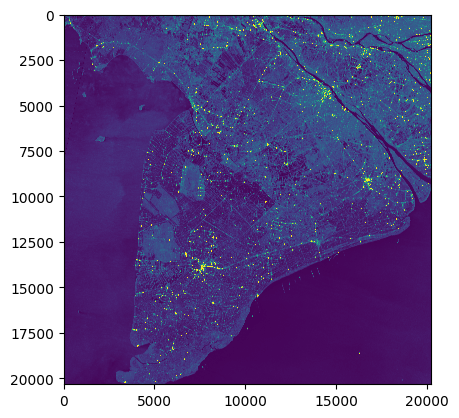

In [8]:
plt.imshow(dsvv.isel(time=0), vmin=0, vmax=1)

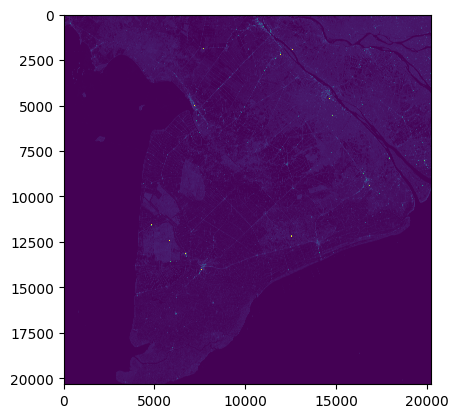

In [11]:
plt.imshow(dsvh.isel(time=0), vmin=0, vmax=1)

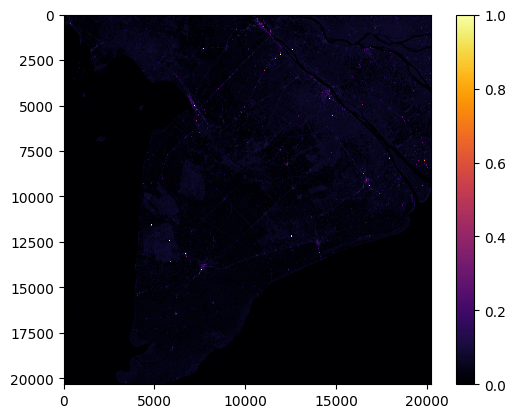

In [14]:
plt.imshow(dsvh.isel(time=0), vmin=0, vmax=1, cmap='inferno')  # or 'plasma', 'inferno', 'cividis'
plt.colorbar()

In [40]:
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 6, y: 3430, x: 6124)
Coordinates:
  * time         (time) datetime64[ns] 2023-09-02T03:35:16.627000 ... 2023-09...
  * y            (y) float64 1.143e+06 1.143e+06 ... 1.109e+06 1.109e+06
  * x            (x) float64 5.489e+05 5.489e+05 ... 6.101e+05 6.101e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [41]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 26.2 ms


VBox()

In [42]:
# calculate NDVI
dsNDVI = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = dsNDVI["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 6, y: 3430, x: 6124)>
dask.array<truediv, shape=(6, 3430, 6124), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2023-09-02T03:35:16.627000 ... 2023-09...
  * y            (y) float64 1.143e+06 1.143e+06 ... 1.109e+06 1.109e+06
  * x            (x) float64 5.489e+05 5.489e+05 ... 6.101e+05 6.101e+05
    spatial_ref  int32 32648

In [43]:
%%time
# calculate average NDVI
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

CPU times: user 15.3 ms, sys: 426 µs, total: 15.8 ms
Wall time: 14.8 ms


VBox()

In [44]:
average_ndvi = average_ndvi.compute()

In [ ]:
plt.imshow(average_ndvi.isel(time=1), vmin=None, vmax=None)
average_ndvi.shape